# Projeto - Interconnect Telecom

A operadora de comunicações Interconnect gostaria de ser capaz de predizer a rotatividade de seus clientes. Se for descoberto que um usuário está planejando trocar de operadora, a empresa oferecerá-lhe códigos promocionais e opções de plano especiais. A equipe de marketing da Interconnect coletou alguns dados pessoais da sua clientela, incluindo a informação sobre seus planos e contratos.

## Serviços da Interconnect

A Interconnect fornece principalmente dois tipos de serviços:

1. Telefonia fixa. O telefone pode ser conectado a várias linhas ao mesmo tempo.
2. Internet. A rede pode ser estabelecida através de uma linha telefônica (DSL, *digital subscriber line - linha digital de assinante*) ou através de um cabo de fibra óptica.

Alguns outros serviços fornecidos pela empresa incluem:

- Segurança na Internet: software de antivírus (*DeviceProtection* - proteção de dispositivos) e um bloqueador de sites maliciosos (*OnlineSecurity* - segurança online).
- Uma linha dedicada de suporte técnico (*TechSupport*).
- Armazenamento de arquivos na nuvem e backup de dados (*OnlineBackup*).
- Streaming de TV (*StreamingTV*) e um diretório de filmes (*StreamingMovies*).

Os clientes podem escolher entre fazer um pagamento mensal e assinar um contrato de 1 ou 2 anos. Eles podem usar vários métodos de pagamento e receber uma fatura eletrônica após a transação.

## Descrição dos Dados

Os dados consistem de arquivos obtidos de fontes diferentes:

- `contract.csv` — informação contratual;
- `personal.csv` — dados pessoais do cliente;
- `internet.csv` — informação sobre serviços de Internet;
- `phone.csv` — informação sobre serviços de telefonia.

Em cada arquivo, a coluna `customerID` contém um código unívoco atribuído a cada cliente. A informação contratual é válida a partir de 1 de fevereiro de 2020.

---

## INVESTIGAÇÃO DOS DADOS

### 1. Análise Exploratória dos Dados (EDA):

In [1]:
# Importações básicas
import pandas as pd
import numpy as np

# Transforme Snake_Case
import inflection

# Impedir avisos
import warnings
warnings.filterwarnings("ignore")

# Criação gráfica
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from plotly.graph_objs import Figure, Histogram
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Balance
from collections import Counter

# Regularization
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix


In [2]:
# Carregue os arquivos de dados em diferentes DataFrames

# Local Path
local_contract_path = "contract.csv"
local_internet_path = "internet.csv"
local_personal_path = "personal.csv"
local_phone_path = "phone.csv"

# Cloud Path
contract_path = "./datasets/contract.csv"
internet_path = "./datasets/internet.csv"
personal_path = "./datasets/personal.csv"
phone_path = "./datasets/phone.csv"


try:
    df_contract = pd.read_csv(local_contract_path, sep=",", parse_dates=True)
    df_internet = pd.read_csv(local_internet_path, sep=",", parse_dates=True)
    df_personal = pd.read_csv(local_personal_path, sep=",", parse_dates=True)
    df_phone = pd.read_csv(local_phone_path, sep=",", parse_dates=True)

except FileNotFoundError:
    print(
        f"O arquivo CSV não foi encontrado em {local_contract_path}. Tentando o caminho {contract_path}..."
    )
    print(
        f"O arquivo CSV não foi encontrado em {local_internet_path}. Tentando o caminho {internet_path}..."
    )
    print(
        f"O arquivo CSV não foi encontrado em {local_personal_path}. Tentando o caminho {personal_path}..."
    )
    print(
        f"O arquivo CSV não foi encontrado em {local_phone_path}. Tentando o caminho {phone_path}..."
    )

    try:
        df_contract = pd.read_csv(contract_path, sep=",", parse_dates=True)
        df_internet = pd.read_csv(internet_path, sep=",", parse_dates=True)
        df_personal = pd.read_csv(personal_path, sep=",", parse_dates=True)
        df_phone = pd.read_csv(phone_path, sep=",", parse_dates=True)

    except FileNotFoundError:
        print(
            f"O arquivo CSV não foi encontrado em {contract_path}. Nenhum arquivo encontrado."
        )
        print(
            f"O arquivo CSV não foi encontrado em {internet_path}. Nenhum arquivo encontrado."
        )
        print(
            f"O arquivo CSV não foi encontrado em {personal_path}. Nenhum arquivo encontrado."
        )
        print(
            f"O arquivo CSV não foi encontrado em {phone_path}. Nenhum arquivo encontrado."
        )

dfs = [df_contract, df_internet, df_personal, df_phone]

O arquivo CSV não foi encontrado em contract.csv. Tentando o caminho ./datasets/contract.csv...
O arquivo CSV não foi encontrado em internet.csv. Tentando o caminho ./datasets/internet.csv...
O arquivo CSV não foi encontrado em personal.csv. Tentando o caminho ./datasets/personal.csv...
O arquivo CSV não foi encontrado em phone.csv. Tentando o caminho ./datasets/phone.csv...


In [3]:
# Checando os dataFrames
for df in dfs:
    display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Todos os dataframes foram importados corretamente.

Sabendo que em cada arquivo, a coluna `custormerID` contém um código unívoco atribuído a cada cliente, então podemos fazer o merge dos dataframes para facilitar.

In [4]:
# Merge dos dataframes

df = (
    df_contract.merge(df_internet, on="customerID", how="outer")
    .merge(df_personal, on="customerID", how="outer")
    .merge(df_phone, on="customerID", how="outer")
)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No


In [5]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


- Temos um total de 7043 dados no dataframe com 20 colunas

- As colunas precisam ser transformadas em snake_case

- `TotalCharges` transformar em float

- `BeingDate` e `EndDate` precisam ser transformada em datetime

In [6]:
# nunique()
df.nunique()

customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
MultipleLines          2
dtype: int64

- Como as variáveis `PaperlessBilling`, `InternetService`, `OnlineSecurity`,`OnlineBackup`, `DeviceProtection`,`TechSupport`, `StreamingTV`, `StreamingMovies`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`,`MultipleLines` apresentam apenas 2 valores unicos como respostas, podemos transformar futuramente, em valores binarios para ficar mais fácil / rápido o aprendizado do modelo

In [7]:
# Checando valores nulos
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

- Nas colunas `InternetService`, `OnlineSecurity`,`OnlineBackup`, `DeviceProtection`,`TechSupport`, `StreamingTV`, `StreamingMovies` e `MultipleLines` têm valores nulos que precisam ser tratados


In [8]:
# checando valores min e max das variáves de tempo
print("Valores Mínimos:")
display(df[["BeginDate", "EndDate"]].min())
print("Valores Máximos:")
display(df[["BeginDate", "EndDate"]].max())

Valores Mínimos:


BeginDate             2013-10-01
EndDate      2019-10-01 00:00:00
dtype: object

Valores Máximos:


BeginDate    2020-02-01
EndDate              No
dtype: object

- Os resultados mostram que os dados possuem valores de BeginDate entre 2013-10-01 e 2020-02-01, e valores de EndDate a partir de 2019-10-01  até datas indefinidas.

In [9]:
df["BeginDate"].value_counts().sort_values()

BeginDate
2013-11-01      2
2013-12-01      3
2013-10-01      3
2014-01-01      7
2020-02-01     11
             ... 
2020-01-01    233
2019-10-01    237
2019-11-01    237
2019-09-01    237
2014-02-01    366
Name: count, Length: 77, dtype: int64

In [10]:
# duplicados
df.duplicated().sum()

0

- Não temos dados duplicados no dataframe

#### 2. Pré-processamento de Dados:

##### 2.1 Transformando em snake_case

In [11]:
# Lista para armazenar os nomes das colunas em snake_case
snake_case_columns = []

# Iterar sobre as colunas e converter para snake_case
for name in df.columns:
    snake_case_columns.append(inflection.underscore(name))

# Atribuir os novos nomes das colunas ao DataFrame
df.columns = snake_case_columns

In [12]:
# checar os novos nomes das colunas
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')

As colunas foram transformada para o estilo snake_case, que é uma boa prática de programação em Python

##### 2.2 FillNa

In [13]:
# FillNa
df.fillna("No", inplace=True)

# Checando se ainda há valores nulos
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

As colunas que possuem valores nulos, como visto antes, são as colunas categóricas, onde as mesmas possuem respostas possíveis como "Yes" ou "No". Então preenchemos os dados nulos como "No"

##### 2.3 Convertendo os dtypes e normalizando as variáveis

- **total_charges**

In [14]:
# Transformando a coluna para numérico
df["total_charges"] = pd.to_numeric(df["total_charges"], errors="coerce")

# Conferindo o dtype
df["total_charges"].dtype

dtype('float64')

In [15]:
# Conferindo se tem valores nulos
df["total_charges"].isna().sum()

11

In [16]:
# Filtrando os resultado com 'total_charges' nulos
df[df["total_charges"].isna()]["total_charges"]

945    NaN
1731   NaN
1906   NaN
2025   NaN
2176   NaN
2250   NaN
2855   NaN
3052   NaN
3118   NaN
4054   NaN
5433   NaN
Name: total_charges, dtype: float64

In [17]:
# Transformando valore nulos em 0
df["total_charges"] = df["total_charges"].fillna(0)

# Checando se todos os valores foram modificados
display(df[df["total_charges"].isna()])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines


Primeiramente, a coluna 'total_charges' foi transformada em float. Ao realizar esse processo, foram encontrados 11 entradas com os valores nulos, pois o uso do "errors='coerce'" trata os possíveis erros como 'NaN'. Dessa forma, como os valores estão nulos, foi preenchido com o valor 0 para esses casos. 

In [18]:
# Describe
df[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


Agora com os dados de cobrança devidamente transformados para valores numéricos, podemos observar o seguinte:

- A média das cobranças mensais é de aproximadamente $64,76 já as cobranças totais chegam a $2279,73
- O maximo de cobrança mensal foi no valor de $118,75 e para as cobranças totais chegaram a $8684,80

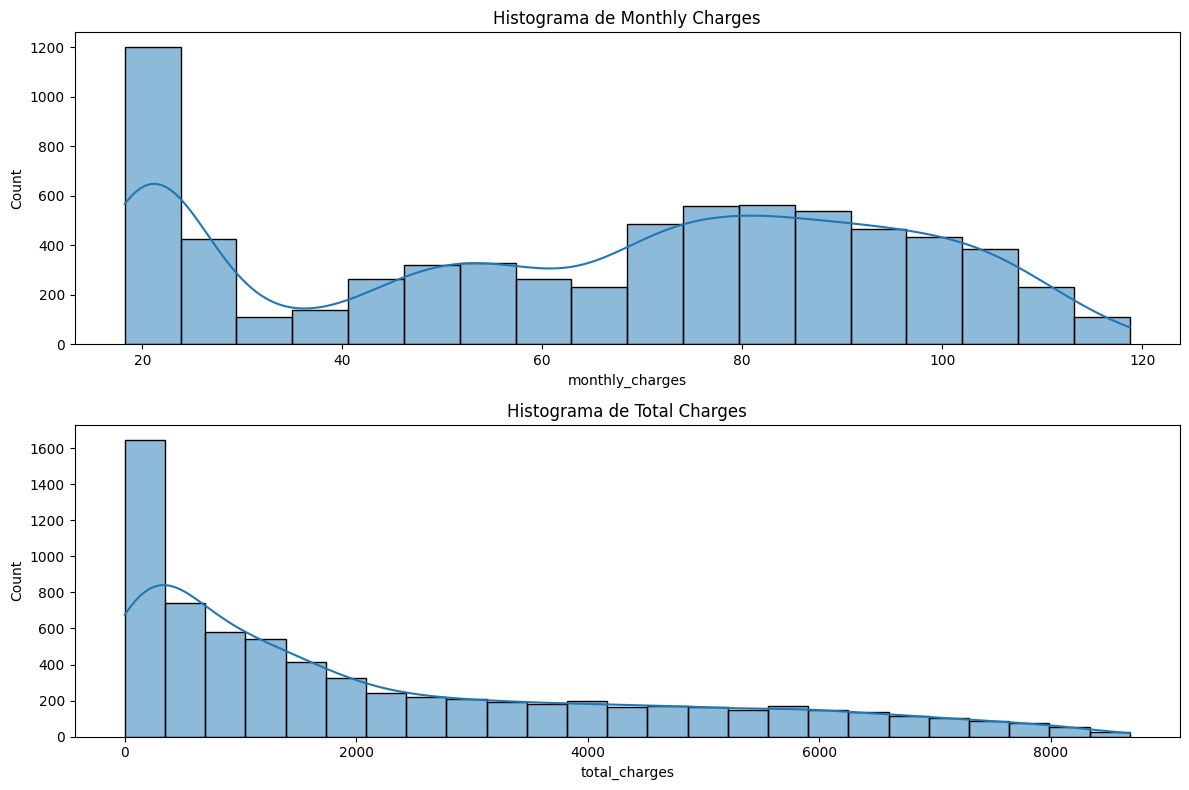

In [19]:
# Plotando histogramas
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Histograma de Monthly Charges
sns.histplot(df['monthly_charges'], kde=True, ax=axes[0])
axes[0].set_title('Histograma de Monthly Charges')

# Histograma de Total Charges
sns.histplot(df['total_charges'], kde=True, ax=axes[1])
axes[1].set_title('Histograma de Total Charges')

plt.tight_layout()
plt.show()


Como podemos ver, as variáveis 'monthly_charges' e 'total_charges' não apresentam uma distribuição normal. Dessa forma, dado que as variáveis não seguem uma distribuição normal, MinMaxScaler pode ser uma abordagem mais apropriada para normalizar os dados. Isso ocorre porque MinMaxScaler não faz suposições sobre a distribuição dos dados e simplesmente escala os valores para um intervalo específico (normalmente [0, 1]).

In [20]:
# Inicializando o MinMaxScaler
scaler = MinMaxScaler()

# Normalizando as variáveis 'monthly_charges' e 'total_charges'
df[['monthly_charges_norm', 'total_charges_norm']] = scaler.fit_transform(df[['monthly_charges', 'total_charges']])


In [21]:
# Checando a normalização
df[['monthly_charges_norm', 'total_charges_norm']].head()

,monthly_charges_norm,total_charges_norm
0,0.471144,0.068315
1,0.414428,0.062454
2,0.553731,0.032338
3,0.793532,0.142531
4,0.653234,0.030789


- **end_date**

In [22]:
# Checando os valores possiveis da coluna 'end_date'
df["end_date"].value_counts()

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

Os valores "No" precisam ser tratados de maneira especial, pois representam situações distintas: clientes ativos (sem churn) e valores possivelmente nulos ou faltantes.

Os outros valores, precisamos transformar em datetime

Vamos tratar valores que não são facilmente convertíveis para uma data, substituindo por uma data padrão, NaT (Not a Time)

In [23]:
# Substituir 'No' e '0' por NaT antes da conversão
df["end_date"] = df["end_date"].replace(["No"], pd.NaT)

# Conversão de datas válidas para datetime
df["end_date"] = pd.to_datetime(df["end_date"], errors="coerce")

- **being_date**

Como visto anteriormente, a coluna 'begin_date' precisava ser transformado em datetime

In [24]:
# Converter a coluna 'begin_date' para datetime
df["begin_date"] = pd.to_datetime(df["begin_date"], errors="coerce")

- **Criação da coluna Churn**

Agora, com os valores corrigidos, podemos criar uma nova coluna, chamada "churn" para separar os usuários ativos e os churn. Essa nova coluna se tornará o nosso objetivo.

In [25]:
# Criando uma coluna para definir se teve churn ou não
df["churn"] = df["end_date"].notna().astype(int)

In [26]:
# Mover a coluna 'churn' para o início
churn_col = df.pop('churn')
df.insert(0, 'churn', churn_col)

Foi criado uma coluna "churn" que indica se o usuário teve churn ou não, onde 1 é igual ao usuário que teve churn na data válida em "end_date", e 0 se o usuário não teve churn em end_date, ou seja, tem valor NaT.

In [27]:
# Criando o subplot com 3 linhas e 3 colunas
fig = make_subplots(
    rows=3,
    cols=3,
    subplot_titles=(
        "Churn x Type",
        "Churn x Paperless Billing",
        "Churn x Payment Method",
        "Churn x Internet Service",
        "Churn x Online Security",
        "Churn x Online Backup",
        "Churn x Gender",
        "Churn x Monthly Charges",
        "Churn x Total Charges",
    ),
)

# Cor a ser utilizada nos gráficos
color_no_churn = "#636EFA"  # Azul
color_churn = "#EF553B"  # Vermelho

# Gráfico 1: Churn x Type
fig.add_trace(
    go.Bar(
        x=df["type"].unique(),
        y=df.loc[df["churn"] == 1, "type"].value_counts(),
        name="Churn",
        marker_color=color_churn,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Bar(
        x=df["type"].unique(),
        y=df.loc[df["churn"] == 0, "type"].value_counts(),
        name="Não Churn",
        marker_color=color_no_churn,
    ),
    row=1,
    col=1,
)

# Gráfico 2: Churn x Paperless Billing
fig.add_trace(
    go.Bar(
        x=df["paperless_billing"].unique(),
        y=df.loc[df["churn"] == 1, "paperless_billing"].value_counts(),
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Bar(
        x=df["paperless_billing"].unique(),
        y=df.loc[df["churn"] == 0, "paperless_billing"].value_counts(),
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=1,
    col=2,
)

# Gráfico 3: Churn x Payment Method
fig.add_trace(
    go.Bar(
        x=df["payment_method"].unique(),
        y=df.loc[df["churn"] == 1, "payment_method"].value_counts(),
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=1,
    col=3,
)
fig.add_trace(
    go.Bar(
        x=df["payment_method"].unique(),
        y=df.loc[df["churn"] == 0, "payment_method"].value_counts(),
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=1,
    col=3,
)

# Gráfico 4: Churn x Internet Service
fig.add_trace(
    go.Bar(
        x=df["internet_service"].unique(),
        y=df.loc[df["churn"] == 1, "internet_service"].value_counts(),
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=2,
    col=1,
)
fig.add_trace(
    go.Bar(
        x=df["internet_service"].unique(),
        y=df.loc[df["churn"] == 0, "internet_service"].value_counts(),
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=2,
    col=1,
)

# Gráfico 5: Churn x Online Security
fig.add_trace(
    go.Bar(
        x=df["online_security"].unique(),
        y=df.loc[df["churn"] == 1, "online_security"].value_counts(),
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=2,
    col=2,
)
fig.add_trace(
    go.Bar(
        x=df["online_security"].unique(),
        y=df.loc[df["churn"] == 0, "online_security"].value_counts(),
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=2,
    col=2,
)

# Gráfico 6: Churn x Online Backup
fig.add_trace(
    go.Bar(
        x=df["online_backup"].unique(),
        y=df.loc[df["churn"] == 1, "online_backup"].value_counts(),
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=2,
    col=3,
)
fig.add_trace(
    go.Bar(
        x=df["online_backup"].unique(),
        y=df.loc[df["churn"] == 0, "online_backup"].value_counts(),
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=2,
    col=3,
)

# Gráfico 7: Churn x Gender
fig.add_trace(
    go.Bar(
        x=df["gender"].unique(),
        y=df.loc[df["churn"] == 1, "gender"].value_counts(),
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=3,
    col=1,
)
fig.add_trace(
    go.Bar(
        x=df["gender"].unique(),
        y=df.loc[df["churn"] == 0, "gender"].value_counts(),
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=3,
    col=1,
)

# Gráfico 8: Churn x Monthly Charges
fig.add_trace(
    go.Histogram(
        x=df.loc[df["churn"] == 1, "monthly_charges"],
        nbinsx=20,
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=3,
    col=2,
)
fig.add_trace(
    go.Histogram(
        x=df.loc[df["churn"] == 0, "monthly_charges"],
        nbinsx=20,
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=3,
    col=2,
)

# Gráfico 9: Churn x Total Charges
fig.add_trace(
    go.Histogram(
        x=df.loc[df["churn"] == 1, "total_charges"],
        nbinsx=20,
        name="Churn",
        showlegend=False,
        marker_color=color_churn,
    ),
    row=3,
    col=3,
)
fig.add_trace(
    go.Histogram(
        x=df.loc[df["churn"] == 0, "total_charges"],
        nbinsx=20,
        showlegend=False,
        marker_color=color_no_churn,
    ),
    row=3,
    col=3,
)

# Ajustando o layout
fig.update_layout(
    title="Relação dos Usuários que Deram Churn",
    title_x=0.5,
    height=800,
    width=1200,
    bargap=0.1,
)

fig.show()

De acordo com os gráficos apresentados, é possível fazer algumas observações interessantes que podem ajudar a empresa a identificar potenciais clientes que possam estar planejando trocar de operadora.

1. Relação entre Churn e o Tipo de contrato:

    - Os clientes com contratos de 1 ano e 2 anos têm menor taxa de churn do que os clientes de contrato mensal.
    - Isso sugere que clientes com contratos de longo prazo são menos propensos a deixar a operadora.

2. Relação entre Churn e Formas de Pagamento:

    - Os clientes que utilizam pagamento por cartão de crédito (automático) têm menor taxa de churn do que aqueles que usam outras formas de pagamento.
    - Isso pode indicar que a conveniência do pagamento automático ajuda a reter os clientes.

3. Relação entre Churn e Serviços Adicionais:

    - Clientes que utilizam serviços adicionais como Backup online e Segurança online têm menor taxa de churn.
    - Isso sugere que oferecer serviços complementares pode ajudar a fidelizar os clientes.

4. Variações por Gênero e Faixa de Cobrança Mensal:

    - Homens e clientes com faturas mensais mais altas tendem a ter taxas de churn um pouco mais baixas.

- **Colunas Categóricas**

Vamos olhar os resultados possíveis de cada uma variável categórica do dataframe

In [28]:
# Verificando os valores possíveis para as variáveis categóricas
cat_columns = df.select_dtypes(include=["object"])
cat_columns = cat_columns.drop("customer_id", axis=1)

for col_name in cat_columns.columns:
    display(cat_columns[col_name].value_counts())

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

internet_service
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

online_security
No     5024
Yes    2019
Name: count, dtype: int64

online_backup
No     4614
Yes    2429
Name: count, dtype: int64

device_protection
No     4621
Yes    2422
Name: count, dtype: int64

tech_support
No     4999
Yes    2044
Name: count, dtype: int64

streaming_tv
No     4336
Yes    2707
Name: count, dtype: int64

streaming_movies
No     4311
Yes    2732
Name: count, dtype: int64

gender
Male      3555
Female    3488
Name: count, dtype: int64

partner
No     3641
Yes    3402
Name: count, dtype: int64

dependents
No     4933
Yes    2110
Name: count, dtype: int64

multiple_lines
No     4072
Yes    2971
Name: count, dtype: int64

Para as variáveis com apenas duas categorias (nunique = 2), o LabelEncoder funciona bem, pois ele atribui 0 ou 1 para cada categoria, transformando-as em variáveis binárias.

Para as variáveis com três ou mais categorias, usar o LabelEncoder poderia ser problemático, pois ele pode atribuir valores numéricos que implicam em uma relação de ordem (por exemplo, 0, 1, 2), o que pode não ser apropriado para todas as variáveis. Nesses casos, uma abordagem comum é usar a codificação one-hot (também chamada de dummy encoding), que cria uma nova coluna para cada categoria com valores binários (0 ou 1) indicando a presença ou ausência de cada categoria.

In [29]:
# Lista das colunas categóricas
binary_cat_cols = cat_columns.columns[cat_columns.nunique() == 2]
multi_cat_cols = cat_columns.columns[cat_columns.nunique() >= 3]

# Cria um objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplica o LabelEncoder para variáveis binárias
for col in binary_cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Aplica get_dummies para variáveis com mais de duas categorias
df = pd.get_dummies(df, columns=multi_cat_cols)

# Converte todas as colunas booleanas para 0 e 1
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [30]:
# checando os resultados
df.head()

,churn,customer_id,begin_date,end_date,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,...,type_Month-to-month,type_One year,type_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_DSL,internet_service_Fiber optic,internet_service_No
0,0,0002-ORFBO,2019-05-01,NaT,1,65.6,593.30,0,1,0,...,0,1,0,0,0,0,1,1,0,0
1,0,0003-MKNFE,2019-05-01,NaT,0,59.9,542.40,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,1,0004-TLHLJ,2019-09-01,2020-01-01,1,73.9,280.85,0,0,1,...,1,0,0,0,0,1,0,0,1,0
3,1,0011-IGKFF,2018-12-01,2020-01-01,1,98.0,1237.85,0,1,1,...,1,0,0,0,0,1,0,0,1,0
4,1,0013-EXCHZ,2019-09-01,2019-12-01,1,83.9,267.40,0,0,0,...,1,0,0,0,0,0,1,0,1,0


- **Removendo as colunas que não parecem ajudar no modelo**

In [31]:
# Drop das colunas que não devem ajudar no modelo
drop_cols = ['customer_id', 'begin_date', 'end_date']
df.drop(drop_cols, axis=1, inplace=True)

In [32]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   churn                                     7043 non-null   int32  
 1   paperless_billing                         7043 non-null   int32  
 2   monthly_charges                           7043 non-null   float64
 3   total_charges                             7043 non-null   float64
 4   online_security                           7043 non-null   int32  
 5   online_backup                             7043 non-null   int32  
 6   device_protection                         7043 non-null   int32  
 7   tech_support                              7043 non-null   int32  
 8   streaming_tv                              7043 non-null   int32  
 9   streaming_movies                          7043 non-null   int32  
 10  gender                              

##### 2.3 Checando o balanceamento da variável objetivo

In [33]:
# Conferindo o balanceamento da variavel churn
def plot_churn_balance_percent(df, title):
        c = Counter(df["churn"])
        keys = list(c.keys())
        count = [c[i] for i in keys]
        total = sum(count)
        percentages = [(c[i] / total) for i in keys]  

        fig = px.bar(x=keys, 
                y=percentages, 
                labels={'x':'Churn',
                        'y':'Frequência em porcentagem'}, 
                title=title)
        fig.update_layout(title_x=0.5)
        fig.show()

In [34]:
# Plotar para cada método de balanceamento
plot_churn_balance_percent(df, "Antes do Balanceamento")

As classes estão desbalanceadas, enquanto há apenas cerca de 26% de clientes que cancelaram, há 73% de clientes que não cancelaram.

Dessa forma, será necessário realizar balanceamento por meio de upsampling, downsampling ou ponderação.

## DESENVOLVIMENTO DO MODELO

### 1. Split do Dataset

In [35]:
# Dividindo o dataset em treinamento (80%) e teste (20%)
train, test = train_test_split(df, test_size=0.2, random_state=12345)

# Dividindo o dataset em treinamento (70%) e validação (30%)
train, valid = train_test_split(train, train_size=0.7, random_state=12345)

In [36]:
# definindo variáveis em X (features) e y (target)

# Conjunto de Treinamento:
features_train = train.drop(["churn"], axis=1)
target_train = train["churn"]

# Conjunto de Validação:
features_valid = valid.drop(["churn"], axis=1)
target_valid = valid["churn"]

# Conjunto de Teste:
features_test = test.drop(["churn"], axis=1)
target_test = test["churn"]

Dividimos o dataset original em conjuto de dados de treinamento, validação e teste. 

Como vimos anteriormente, o dataset está desbalanceado. Vamos fazer o balanceamento nos conjuntos de dados de treinamento apenas.

- **Random Over Sampler**

In [37]:
# Instanciando os resampleadores
over_sampler = RandomOverSampler()

# Aplicando os resampleadores
features_train_ros, target_train_ros = over_sampler.fit_resample(features_train, target_train)

# Criando DataFrames para oversampling
df_over = pd.DataFrame(features_train_ros, columns=features_train.columns)
df_over['churn'] = target_train_ros

Para o balanceamento do conjunto de dados de treinamento por Over Sampler, vai ser feito o aumento das classes minoritárias, ou seja, Adicionam-se novas instâncias à classe minoritária por meio de duplicação aleatória das instâncias existentes, aumentando o número de exemplos dessa classe para igualar ou se aproximar do número de exemplos da classe majoritária.

- **Random Under Sampler**

In [38]:
# Instanciando os resampleadores
under_sampler = RandomUnderSampler()

# Aplicando os resampleadores
features_train_rus, target_train_rus = under_sampler.fit_resample(features_train, target_train)

# Criando DataFrames para undersampling
df_under = pd.DataFrame(features_train_rus, columns=features_train.columns)
df_under['churn'] = target_train_rus

Já para o balanceamento do conjunto de dados de treinamento por Under Sampler, vai ser a redução da classe majoritária, ou seja, Remove-se aleatoriamente uma parte das instâncias da classe majoritária para diminuir o desbalanceamento. Isso ajuda a reduzir o número de exemplos da classe majoritária, tornando o conjunto de dados mais manejável e menos tendencioso.

In [39]:
# Criando gráficos
fig = px.histogram(train, x='churn', title='Original Training Set', nbins=2)
fig_over = px.histogram(df_over, x='churn', title='Oversampled Training Set', nbins=2)
fig_under = px.histogram(df_under, x='churn', title='Undersampled Training Set', nbins=2)

# Atualizando os layouts dos gráficos
fig.update_layout(bargap=0.2)
fig_over.update_layout(bargap=0.2)
fig_under.update_layout(bargap=0.2)


fig_combined = make_subplots(
    rows=1, cols=3, 
    subplot_titles=("Original Training Set", "Oversampled Training Set", "Undersampled Training Set"),
    shared_yaxes=True
)

# Adicionando os gráficos aos subplots
fig_combined.add_trace(Histogram(x=train['churn']), row=1, col=1)
fig_combined.add_trace(Histogram(x=df_over['churn']), row=1, col=2)
fig_combined.add_trace(Histogram(x=df_under['churn']), row=1, col=3)

# Atualizando layout dos subplots
fig_combined.update_layout(
    title_text="Distribuição de 'churn' no Conjunto de Treinamento",
    bargap=0.2,
    showlegend=False,
    title_x=0.5
)
fig_combined.show()

In [40]:
# Criando a tabela de shapes
shapes_data = {
    "Dataset": ["Training Set", "Validation Set", "Test Set", "Oversampled Training Set", "Undersampled Training Set"],
    "Features Shape": [features_train.shape, features_valid.shape, features_test.shape, features_train_ros.shape, features_train_rus.shape],
    "Target Shape": [target_train.shape, target_valid.shape, target_test.shape, target_train_ros.shape, target_train_rus.shape]
}

shapes_df = pd.DataFrame(shapes_data)
print(shapes_df)

                     Dataset Features Shape Target Shape
0               Training Set     (3943, 26)      (3943,)
1             Validation Set     (1691, 26)      (1691,)
2                   Test Set     (1409, 26)      (1409,)
3   Oversampled Training Set     (5788, 26)      (5788,)
4  Undersampled Training Set     (2098, 26)      (2098,)


Com os dados da tabela e o gráfico acima, podemos dizer que:

1. Original:

    - O conjunto de dados original é desbalanceado, o que pode levar a um modelo tendencioso, favorecendo a classe majoritária.

2. Over Sampler:

    - O aumento do conjunto de dados através de sobreajustamento (de 3943 para 5792 observações) equilibrou as classes, adicionando instâncias duplicadas da classe minoritária.

    - Este método aumenta a quantidade de dados disponíveis para treinamento, validação e teste, mas pode introduzir o risco de sobreajuste, pois as novas instâncias são duplicatas e não adicionam variabilidade.

3. Under Sampler:

    - A redução do conjunto de dados através de subajustamento (de 3943 para 2094 observações) equilibrou as classes, removendo instâncias da classe majoritária.

    - Este método reduz a quantidade de dados disponíveis, o que pode levar à perda de informações importantes da classe majoritária, mas ajuda a evitar a tendência para a classe majoritária.

### 2. Treinando o Modelo

In [41]:
def evaluate_model(model, train_features, train_target, valid_features, valid_target, test_features, test_target):
    eval_stats = {}

    fig, ax = plt.subplots(figsize=(10, 6))

    for type, features, target in (
        ("train", train_features, train_target),
        ("valid", valid_features, valid_target),
        ("test", test_features, test_target),
    ):
        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # ROC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)
        eval_stats[type]["ROC AUC"] = roc_auc

        # Accuracy
        eval_stats[type]["Accuracy"] = accuracy_score(target, pred_target)

        if type == "train":
            color = "blue"
        elif type == "test":
            color = "green"
        else:
            color = "yellow"

        # ROC
        ax.plot(fpr, tpr, color=color, label=f"{type}, ROC AUC={roc_auc:.2f}")
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                fpr[closest_value_idx],
                tpr[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )

    ax.plot([0, 1], [0, 1], color="grey", linestyle="--")
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")
    ax.set_title(f"ROC Curve")

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=("Accuracy", "ROC AUC"))

    print(df_eval_stats)

    return df_eval_stats

##### 2.1 Modelos com dataset original

- **Dummy Classifier**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores parâmetros encontrados: {'strategy': 'stratified'}
          train  valid  test
Accuracy   0.61   0.60  0.61
ROC AUC    0.49   0.49  0.49


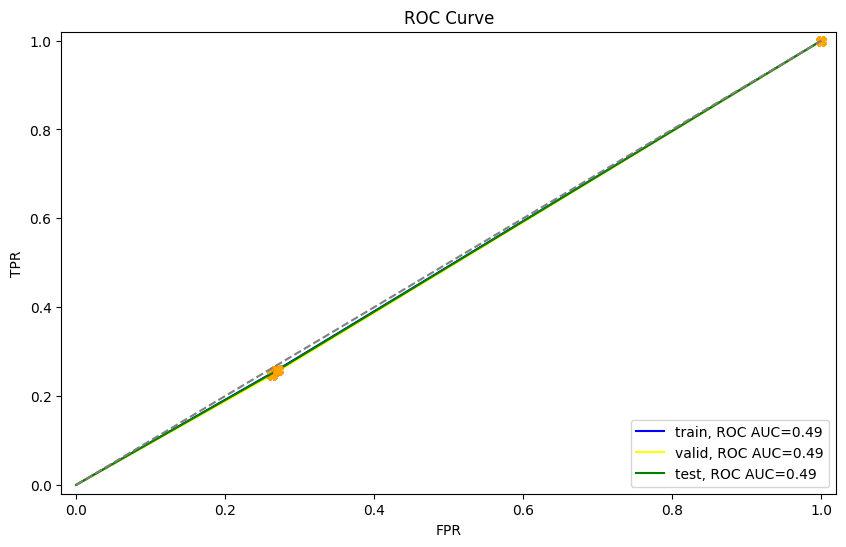

In [42]:
# Parâmetros para o DummyClassifier
param_grid = {"strategy": ["stratified", "most_frequent", "prior", "uniform"]}

# Instanciando o DummyClassifier
base_model = DummyClassifier(random_state=12345)

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Executando a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train, target_train)

# Obtendo os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avaliando o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train, target_train, features_valid, target_valid, features_test, target_test
)

In [43]:
acc_baseline = result['test']['Accuracy']
roc_auc_baseline = result['test']['ROC AUC']
best_param_baseline = best_params
best_model_baseline = best_model

- **Logistic Regression**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'C': 1}
          train  valid  test
Accuracy   0.80   0.79  0.80
ROC AUC    0.84   0.83  0.85


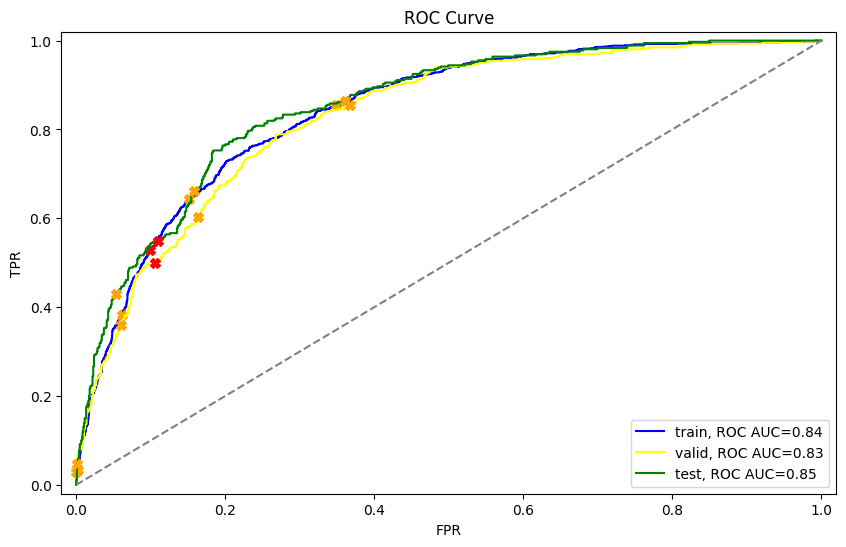

In [44]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg = LogisticRegression(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train, target_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train, target_train, features_valid, target_valid, features_test, target_test
)

In [45]:
acc_LR = result['test']['Accuracy']
roc_auc_LR = result['test']['ROC AUC']
best_param_LR = best_params
best_model_LR = best_model

- **Logistic Regression + Class Weight Correction**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'C': 0.1}
          train  valid  test
Accuracy   0.75   0.74  0.76
ROC AUC    0.84   0.83  0.85


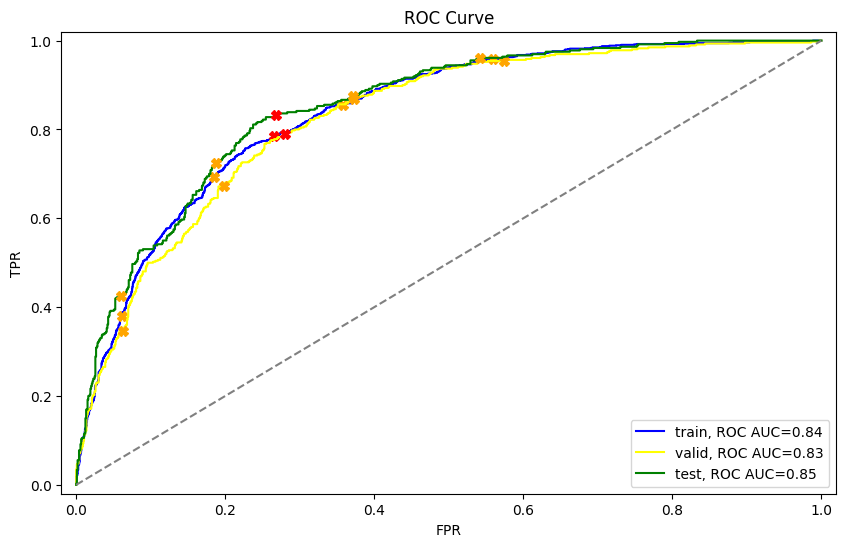

In [46]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg_balanced = LogisticRegression(random_state=12345, class_weight="balanced")

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_balanced,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train, target_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train, target_train, features_valid, target_valid, features_test, target_test
)

In [47]:
acc_LR_class_weight = result['test']['Accuracy']
roc_auc_LR_class_weight = result['test']['ROC AUC']
best_param_LR_class_weight = best_params
best_model_LR_class_weight = best_model

- **Random Forest Classifier**

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
          train  valid  test
Accuracy   0.86   0.79  0.81
ROC AUC    0.93   0.83  0.86


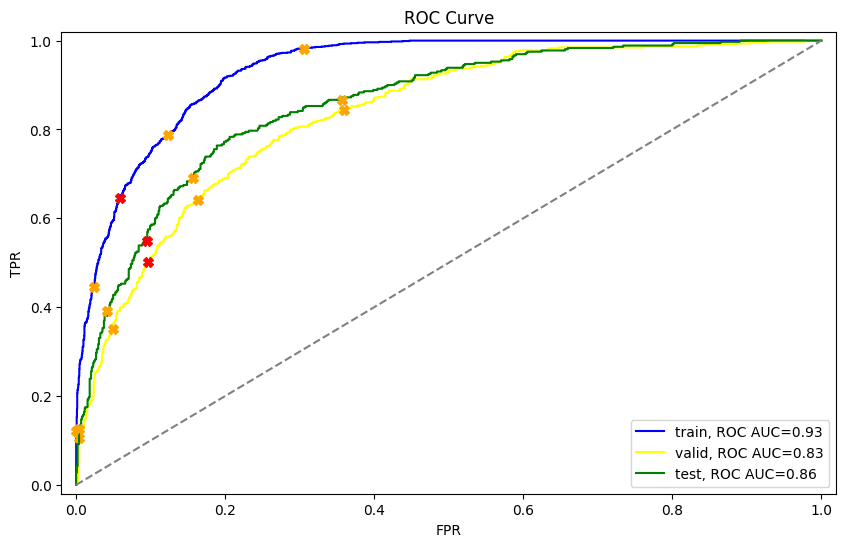

In [48]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rfc = RandomForestClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=rfc, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train, target_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train, target_train, features_valid, target_valid, features_test, target_test
)

In [49]:
acc_rfc = result['test']['Accuracy']
roc_auc_rfc = result['test']['ROC AUC']
best_param_rfc = best_params
best_model_rfc = best_model

- **LGBM**

Fitting 5 folds for each of 27 candidates, totalling 135 fits


  File "c:\Users\pedro\Desktop\Pedro\code\portfolio_projetos\interconect-telecom\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1049, number of negative: 2894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 3943, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266041 -> initscore=-1.014802
[LightGBM] [Info] Start training from score -1.014802
Melhores parâmetros encontrados: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200}
          train  valid  test
Accuracy   0.84   0.79  0.81
ROC AUC    0.89   0.83  0.86


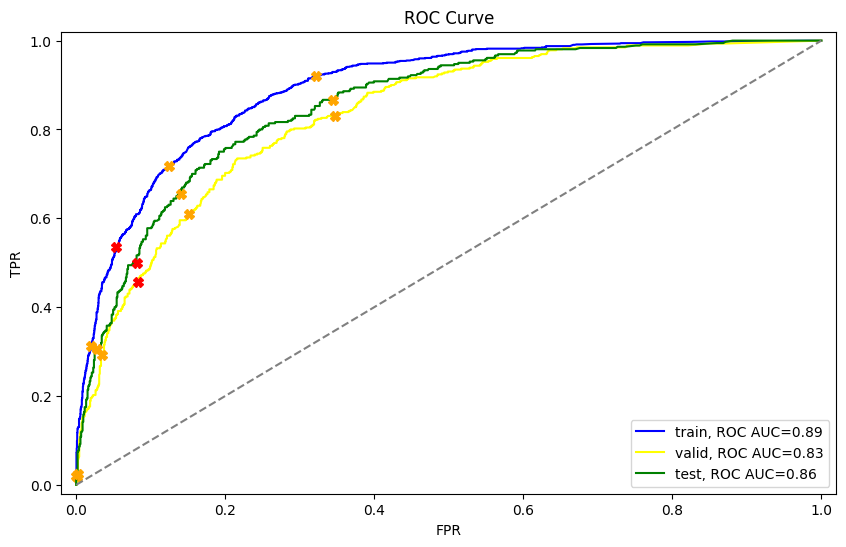

In [50]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.1, 0.5],
}

lgbm = LGBMClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train, target_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train, target_train, features_valid, target_valid, features_test, target_test
)

In [51]:
acc_LGBM = result['test']['Accuracy']
roc_auc_LGBM = result['test']['ROC AUC']
best_param_LGBM = best_params
best_model_LGBM = best_model

- **CatBoost**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.6866349	total: 173ms	remaining: 34.5s
1:	learn: 0.6793719	total: 179ms	remaining: 17.7s
2:	learn: 0.6723983	total: 185ms	remaining: 12.1s
3:	learn: 0.6660235	total: 190ms	remaining: 9.29s
4:	learn: 0.6595896	total: 194ms	remaining: 7.58s
5:	learn: 0.6531187	total: 199ms	remaining: 6.44s
6:	learn: 0.6466898	total: 204ms	remaining: 5.63s
7:	learn: 0.6406146	total: 209ms	remaining: 5.03s
8:	learn: 0.6347596	total: 214ms	remaining: 4.55s
9:	learn: 0.6288656	total: 218ms	remaining: 4.13s
10:	learn: 0.6238782	total: 220ms	remaining: 3.78s
11:	learn: 0.6184619	total: 225ms	remaining: 3.52s
12:	learn: 0.6134059	total: 230ms	remaining: 3.3s
13:	learn: 0.6081881	total: 235ms	remaining: 3.12s
14:	learn: 0.6030314	total: 240ms	remaining: 2.96s
15:	learn: 0.5977586	total: 245ms	remaining: 2.81s
16:	learn: 0.5936945	total: 247ms	remaining: 2.66s
17:	learn: 0.5889916	total: 252ms	remaining: 2.55s
18:	learn: 0.5847160	total: 256

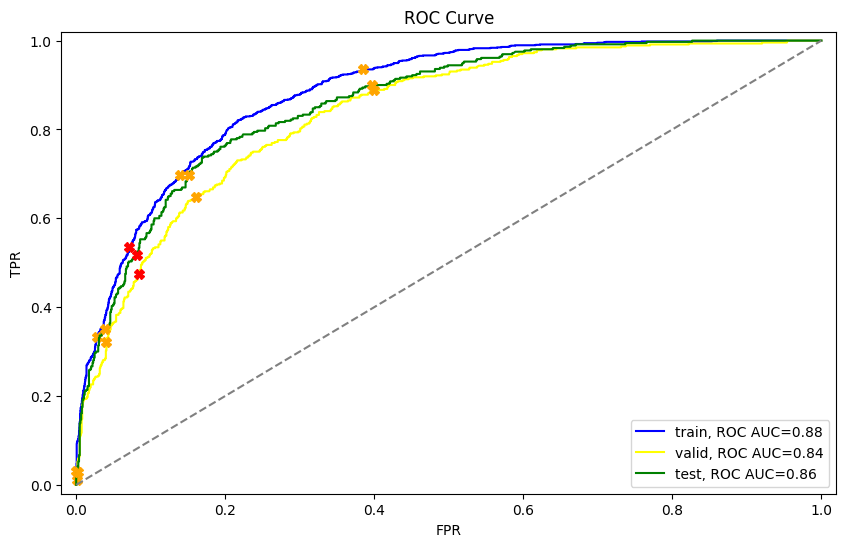

In [52]:
param_grid = {
    "iterations": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5],
    "depth": [4, 6, 8],
}

cat_boost = CatBoostClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_boost,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train, target_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train, target_train, features_valid, target_valid, features_test, target_test
)

In [53]:
acc_cat_boost = result['test']['Accuracy']
roc_auc_cat_boost = result['test']['ROC AUC']
best_param_cat_boost = best_params
best_model_cat_boost = best_model

- **Resultados dos Modelos**

In [54]:
# Configuração para exibir todo o texto na coluna "Melhores Parâmetros"
pd.set_option('display.max_colwidth', None)\

models = pd.DataFrame(
    {
        "Model": [
            "Baseline",
            "LR",
            "LR+Class weight",
            "RFC",
            "LGBM",
            "CatBoost",
        ],
        "Accuracy": [
            acc_baseline,
            acc_LR,
            acc_LR_class_weight,
            acc_rfc,
            acc_LGBM,
            acc_cat_boost,
        ],
        "ROC_AUC": [
            roc_auc_baseline,
            roc_auc_LR,
            roc_auc_LR_class_weight,
            roc_auc_rfc,
            roc_auc_LGBM,
            roc_auc_cat_boost,
        ],
        "Melhores Parâmetros": [
            best_param_baseline,
            best_param_LR,
            best_param_LR_class_weight,
            best_param_rfc,
            best_param_LGBM,
            best_param_cat_boost
        ]
    }
)

display(models)

,Model,Accuracy,ROC_AUC,Melhores Parâmetros
0,Baseline,0.61,0.49,{'strategy': 'stratified'}
1,LR,0.80,0.85,{'C': 1}
2,LR+Class weight,0.76,0.85,{'C': 0.1}
3,RFC,0.81,0.86,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}"
4,LGBM,0.81,0.86,"{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200}"
5,CatBoost,0.82,0.86,"{'depth': 8, 'iterations': 200, 'learning_rate': 0.01}"


- Conclusões sobre os modelos apresentados, para o conjunto de dados de teste:

    - Modelos Baseline vs. Avançados: O modelo de linha de base tem uma ROC AUC de 0.50, indicando que ele não faz um bom trabalho em discriminar entre as classes. Em contraste, todos os outros modelos têm uma ROC AUC acima de 0.84, mostrando uma habilidade discriminativa substancialmente melhor.

    - Logistic Regression (LR): Tanto a versão padrão quanto a versão com pesos ajustados para as classes têm um bom desempenho em termos de ROC AUC. No entanto, ajustar os pesos das classes impacta negativamente a acurácia.

    - Modelos de Ensemble (RFC, LGBM, CatBoost): Esses modelos têm um desempenho muito similar, todos com uma acurácia de 0.80 e um ROC AUC de 0.84, com exceção do RFC que tem ROC AUC 0.85, sugerindo que eles estão bem ajustados ao conjunto de dados. Os parâmetros refletem abordagens diferentes para evitar overfitting e melhorar a performance.

##### 2.2 Modelos com balanceamento Over Sampler

- **Dummy Classifier**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores parâmetros encontrados: {'strategy': 'most_frequent'}
          train  valid  test
Accuracy    0.5   0.73  0.74
ROC AUC     0.5   0.50  0.50


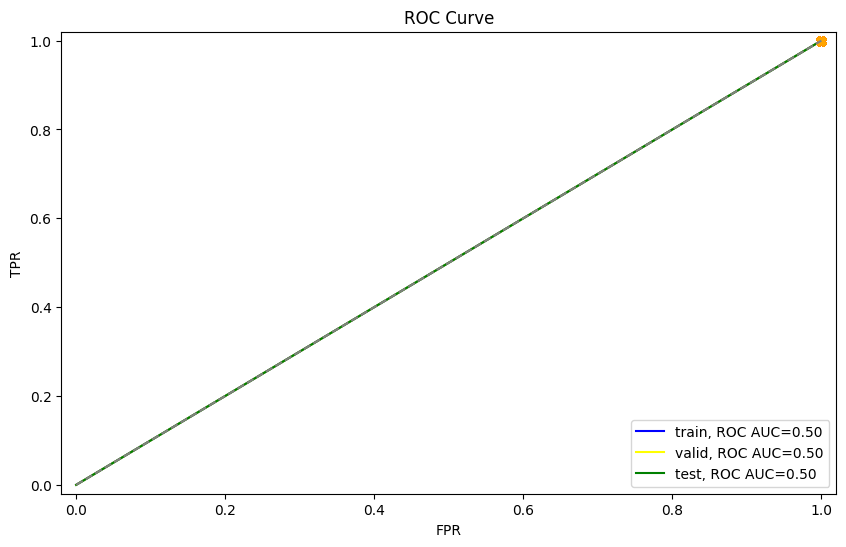

In [55]:
param_grid = {"strategy": ["stratified", "most_frequent", "prior", "uniform"]}

base_model = DummyClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_ros, target_train_ros)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_ros, target_train_ros, features_valid, target_valid, features_test, target_test
)

In [56]:
acc_baseline_o = result['test']['Accuracy']
roc_auc_baseline_o = result['test']['ROC AUC']
best_param_baseline_o = best_params
best_model_baseline_o = best_model

- **Logistic Regression**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'C': 0.1}
          train  valid  test
Accuracy   0.76   0.74  0.76
ROC AUC    0.84   0.83  0.85


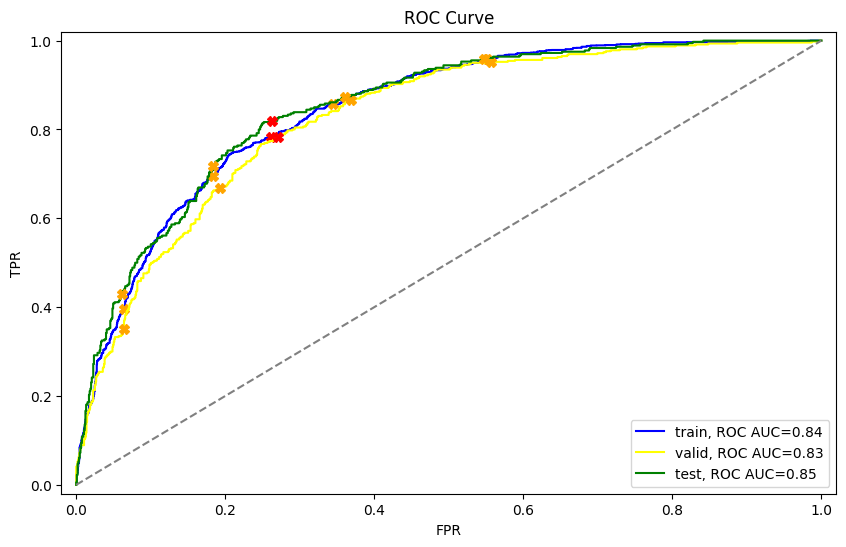

In [57]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg = LogisticRegression(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_ros, target_train_ros)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_ros, target_train_ros, features_valid, target_valid, features_test, target_test
)

In [58]:
acc_LR_o = result['test']['Accuracy']
roc_auc_LR_o = result['test']['ROC AUC']
best_param_LR_o = best_params
best_model_LR_o = best_model

- **Logistic Regression + Class Weight Correction**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'C': 0.1}
          train  valid  test
Accuracy   0.76   0.74  0.76
ROC AUC    0.84   0.83  0.85


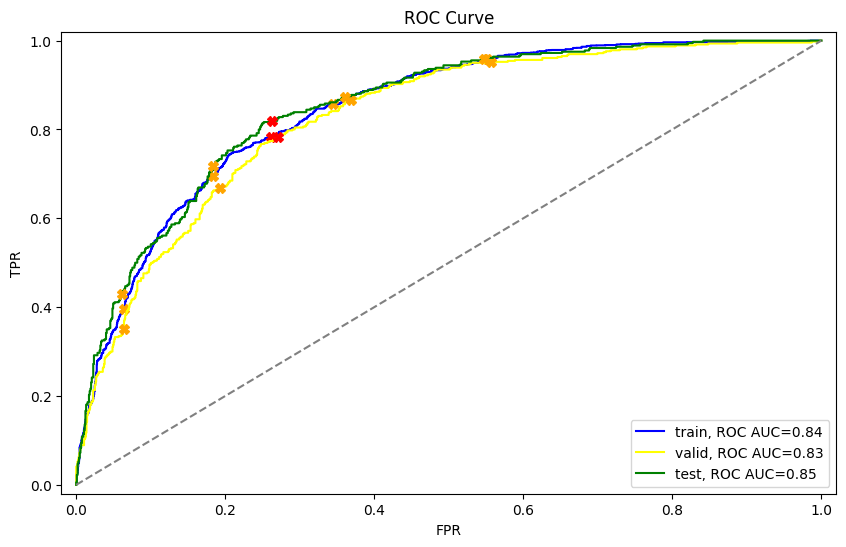

In [59]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg_balanced = LogisticRegression(random_state=12345, class_weight="balanced")

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_balanced,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_ros, target_train_ros)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_ros, target_train_ros, features_valid, target_valid, features_test, target_test
)

In [60]:
acc_LR_class_weight_o = result['test']['Accuracy']
roc_auc_LR_class_weight_o = result['test']['ROC AUC']
best_param_LR_class_weight_o = best_params
best_model_LR_class_weight_o = best_model

- **Random Forest Classifier**

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
          train  valid  test
Accuracy    1.0   0.78  0.80
ROC AUC     1.0   0.82  0.84


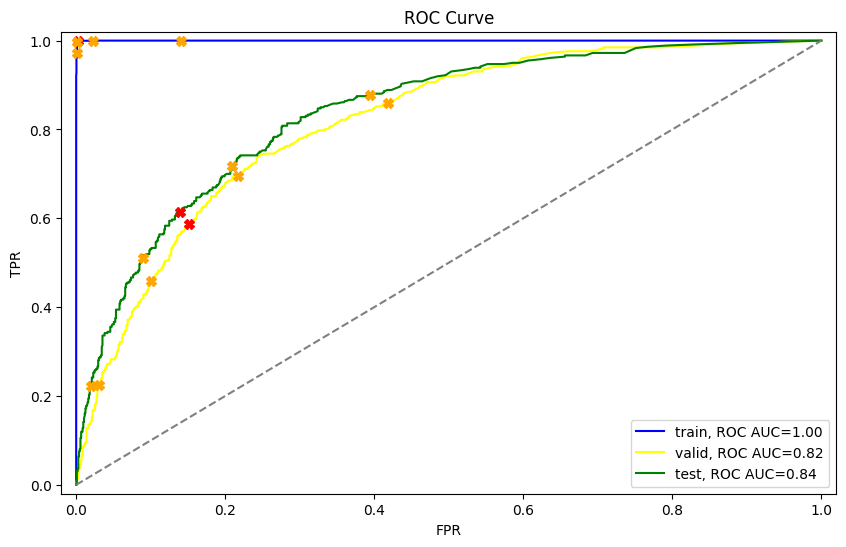

In [61]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rfc = RandomForestClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=rfc, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_ros, target_train_ros)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_ros, target_train_ros, features_valid, target_valid, features_test, target_test
)

In [62]:
acc_rfc_o = result['test']['Accuracy']
roc_auc_rfc_o = result['test']['ROC AUC']
best_param_rfc_o = best_params
best_model_rfc_o = best_model

- **LGBM**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2894, number of negative: 2894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 5788, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros encontrados: {'learning_rate': 0.5, 'max_depth': -1, 'n_estimators': 200}
          train  valid  test
Accuracy    1.0   0.76  0.77
ROC AUC     1.0   0.80  0.80


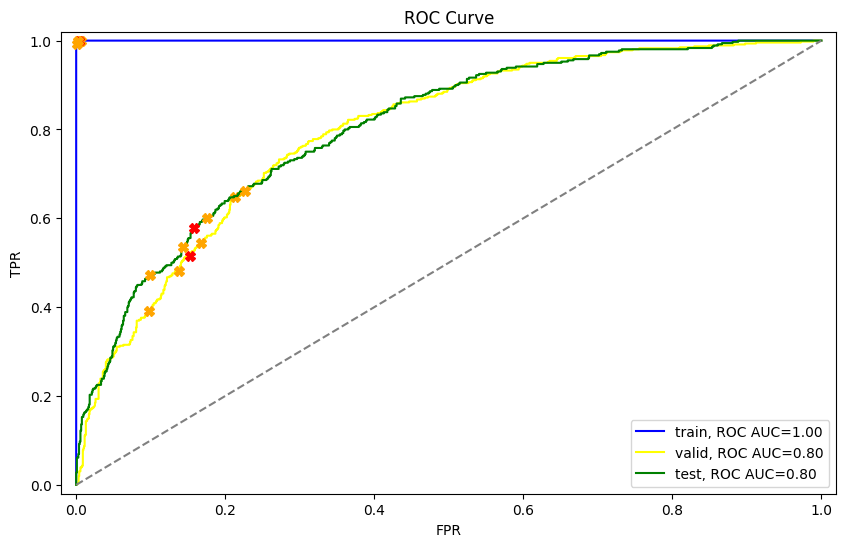

In [63]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.1, 0.5],
}

lgbm = LGBMClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_ros, target_train_ros)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_ros, target_train_ros, features_valid, target_valid, features_test, target_test
)

In [64]:
acc_LGBM_o = result['test']['Accuracy']
roc_auc_LGBM_o = result['test']['ROC AUC']
best_param_LGBM_o = best_params
best_model_LGBM_o = best_model

- **CatBoost**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.5527781	total: 14.7ms	remaining: 2.93s
1:	learn: 0.4841088	total: 19.5ms	remaining: 1.93s
2:	learn: 0.4605155	total: 24.3ms	remaining: 1.59s
3:	learn: 0.4357972	total: 28.4ms	remaining: 1.39s
4:	learn: 0.4270638	total: 32.7ms	remaining: 1.27s
5:	learn: 0.4097883	total: 36.9ms	remaining: 1.19s
6:	learn: 0.3961182	total: 41.3ms	remaining: 1.14s
7:	learn: 0.3913857	total: 46ms	remaining: 1.1s
8:	learn: 0.3824966	total: 50.2ms	remaining: 1.06s
9:	learn: 0.3750214	total: 54.8ms	remaining: 1.04s
10:	learn: 0.3727387	total: 59.5ms	remaining: 1.02s
11:	learn: 0.3620169	total: 63.9ms	remaining: 1s
12:	learn: 0.3549741	total: 68ms	remaining: 978ms
13:	learn: 0.3464874	total: 72.3ms	remaining: 961ms
14:	learn: 0.3400709	total: 77ms	remaining: 950ms
15:	learn: 0.3352777	total: 81.4ms	remaining: 936ms
16:	learn: 0.3249903	total: 85.8ms	remaining: 924ms
17:	learn: 0.3164628	total: 90.9ms	remaining: 919ms
18:	learn: 0.3118409	t

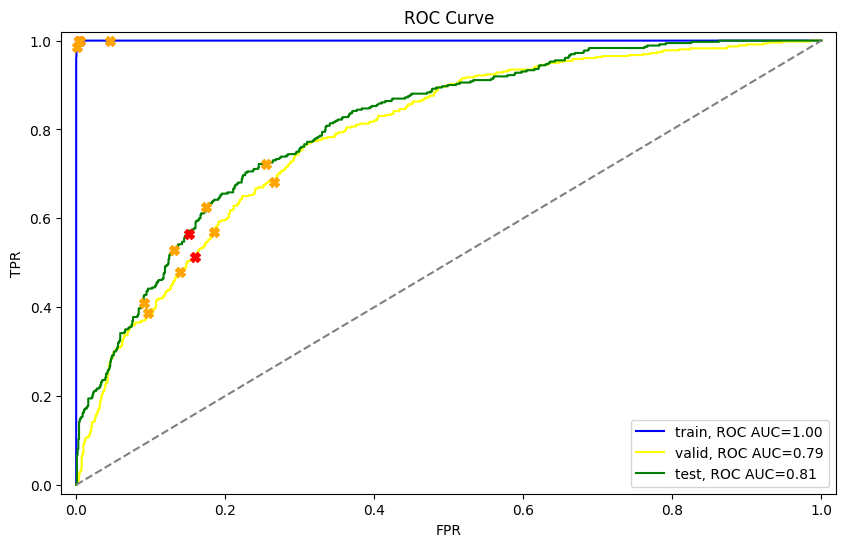

In [65]:
param_grid = {
    "iterations": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5],
    "depth": [4, 6, 8],
}

cat_boost = CatBoostClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_boost,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_ros, target_train_ros)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_ros, target_train_ros, features_valid, target_valid, features_test, target_test
)

In [66]:
acc_cat_boost_o = result['test']['Accuracy']
roc_auc_cat_boost_o = result['test']['ROC AUC']
best_param_cat_boost_o = best_params
best_model_cat_boost_o = best_model

- **Resultados dos Modelos**

In [67]:
models = pd.DataFrame(
    {
        "Model": [
            "Baseline Over Sampler",
            "LR Over Sampler",
            "LR+Class weight Over Sampler",
            "RFC Over Sampler",
            "LGBM Over Sampler",
            "CatBoost Over Sampler",
        ],
        "Accuracy": [
            acc_baseline_o,
            acc_LR_o,
            acc_LR_class_weight_o,
            acc_rfc_o,
            acc_LGBM_o,
            acc_cat_boost_o,
        ],
        "ROC_AUC": [
            roc_auc_baseline_o,
            roc_auc_LR_o,
            roc_auc_LR_class_weight_o,
            roc_auc_rfc_o,
            roc_auc_LGBM_o,
            roc_auc_cat_boost_o,
        ],
        "Melhores Parâmetros": [
            best_param_baseline_o,
            best_param_LR_o,
            best_param_LR_class_weight_o,
            best_param_rfc_o,
            best_param_LGBM_o,
            best_param_cat_boost_o
        ]
    }
)

display(models)

,Model,Accuracy,ROC_AUC,Melhores Parâmetros
0,Baseline Over Sampler,0.74,0.50,{'strategy': 'most_frequent'}
1,LR Over Sampler,0.76,0.85,{'C': 0.1}
2,LR+Class weight Over Sampler,0.76,0.85,{'C': 0.1}
3,RFC Over Sampler,0.80,0.84,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}"
4,LGBM Over Sampler,0.77,0.80,"{'learning_rate': 0.5, 'max_depth': -1, 'n_estimators': 200}"
5,CatBoost Over Sampler,0.78,0.81,"{'depth': 8, 'iterations': 200, 'learning_rate': 0.5}"


- Modelos Baseline vs. Avançados: O modelo de linha de base tem acurácia relativamente boa e ROC AUC muito baixos, indicando que ele não é eficaz após o sobreajustamento. Todos os outros modelos têm uma ROC AUC superior a 0.80, mostrando boa habilidade discriminativa.

- Modelos de Regressão Logística: Tanto a regressão logística simples quanto a versão com pesos ajustados mostram bons desempenhos, com uma ROC AUC de 0.84. Isso sugere que o sobreajustamento ajudou a melhorar a performance desses modelos. Tornando-os modelos com melhores desempenhos quando se faz o balanceamento por Over Sampler.

- Modelos de Ensemble (RFC, LGBM, CatBoost): O Random Forest Classifier (RFC) tem um desempenho, com uma acurácia de 0.78 e ROC AUC de 0.82, indicando uma boa capacidade de discriminação. LightGBM e CatBoost também apresentam desempenhos bons, com acurácia de 0.76, e ROC AUC de 0.80, sugerindo que eles são modelos eficazes.

##### 2.3 Modelos com balanceamento Under Sampler

- **Dummy Classifier**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores parâmetros encontrados: {'strategy': 'stratified'}
          train  valid  test
Accuracy   0.52    0.5  0.49
ROC AUC    0.52    0.5  0.49


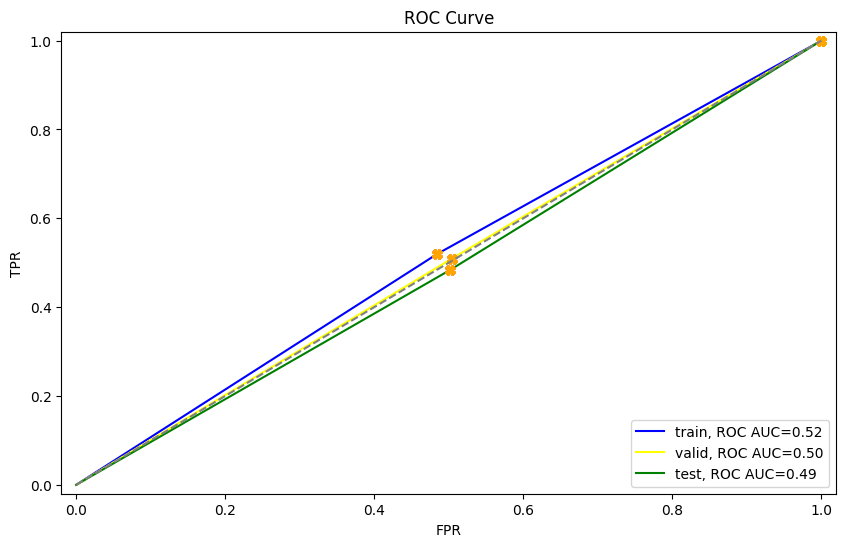

In [68]:
param_grid = {"strategy": ["stratified", "most_frequent", "prior", "uniform"]}

base_model = DummyClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_rus, target_train_rus)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_rus, target_train_rus, features_valid, target_valid, features_test, target_test
)

In [69]:
acc_baseline_u = result['test']['Accuracy']
roc_auc_baseline_u = result['test']['ROC AUC']
best_param_baseline_u = best_params
best_model_baseline_u = best_model

- **Logistic Regression**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'C': 0.1}
          train  valid  test
Accuracy   0.76   0.74  0.76
ROC AUC    0.85   0.82  0.85


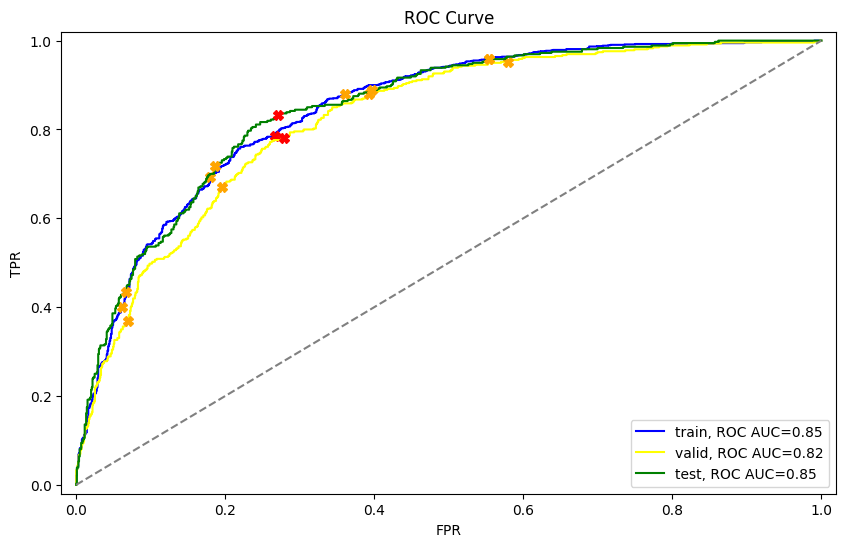

In [70]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg = LogisticRegression(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_rus, target_train_rus)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_rus, target_train_rus, features_valid, target_valid, features_test, target_test
)

In [71]:
acc_LR_u = result['test']['Accuracy']
roc_auc_LR_u = result['test']['ROC AUC']
best_param_LR_u = best_params
best_model_LR_u = best_model

- **Logistic Regression + Class Weight Correction**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros encontrados: {'C': 0.1}
          train  valid  test
Accuracy   0.76   0.74  0.76
ROC AUC    0.85   0.82  0.85


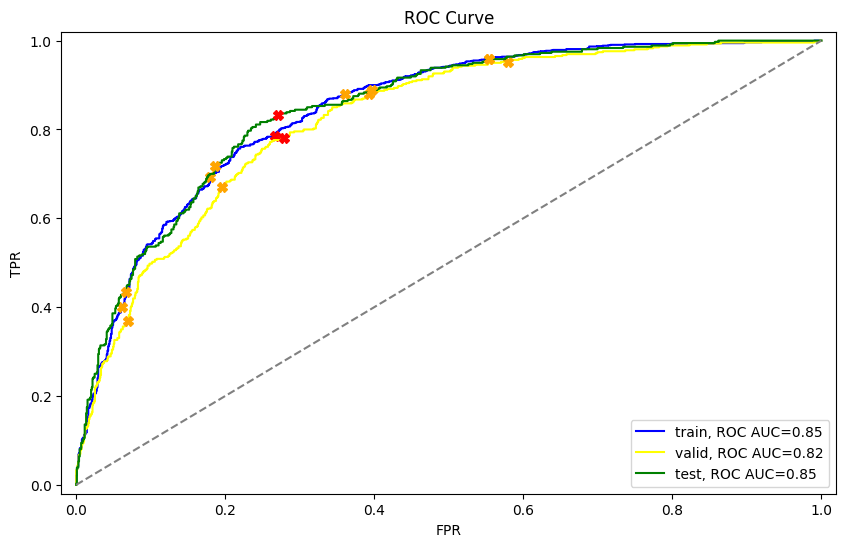

In [72]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg_balanced = LogisticRegression(random_state=12345, class_weight="balanced")

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_balanced,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_rus, target_train_rus)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_rus, target_train_rus, features_valid, target_valid, features_test, target_test
)

In [73]:
acc_LR_class_weight_u = result['test']['Accuracy']
roc_auc_LR_class_weight_u = result['test']['ROC AUC']
best_param_LR_class_weight_u = best_params
best_model_LR_class_weight_u = best_model

- **Random Forest Classifier**

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
          train  valid  test
Accuracy   0.86   0.74  0.74
ROC AUC    0.94   0.83  0.85


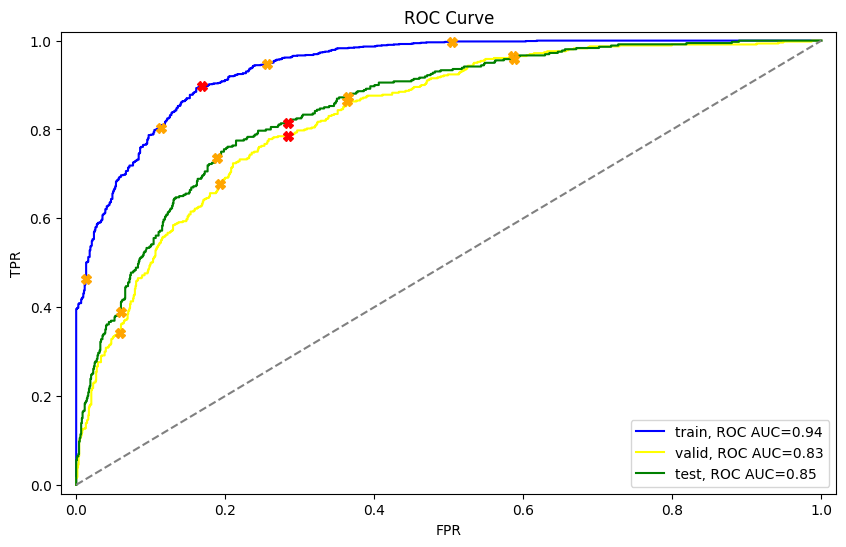

In [74]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rfc = RandomForestClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=rfc, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_rus, target_train_rus)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_rus, target_train_rus, features_valid, target_valid, features_test, target_test
)

In [75]:
acc_rfc_u = result['test']['Accuracy']
roc_auc_rfc_u = result['test']['ROC AUC']
best_param_rfc_u = best_params
best_model_rfc_u = best_model

- **LGBM**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1049, number of negative: 1049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 2098, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros encontrados: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
          train  valid  test
Accuracy   0.82   0.74  0.75
ROC AUC    0.91   0.83  0.84


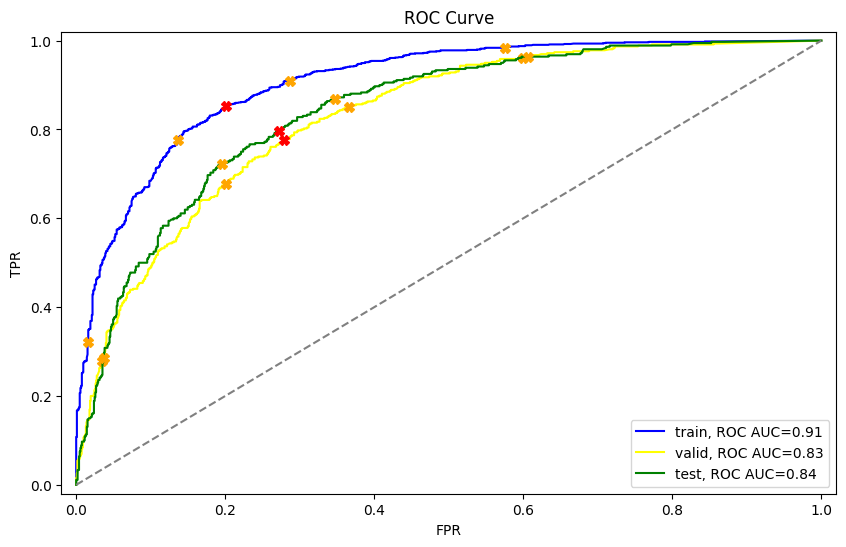

In [76]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.1, 0.5],
}

lgbm = LGBMClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_rus, target_train_rus)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_rus, target_train_rus, features_valid, target_valid, features_test, target_test
)

In [77]:
acc_LGBM_u = result['test']['Accuracy']
roc_auc_LGBM_u = result['test']['ROC AUC']
best_param_LGBM_u = best_params
best_model_LGBM_u = best_model

- **CatBoost**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.6557867	total: 1.85ms	remaining: 90.6ms
1:	learn: 0.6235388	total: 3.52ms	remaining: 84.6ms
2:	learn: 0.5973944	total: 4.96ms	remaining: 77.7ms
3:	learn: 0.5751667	total: 6.38ms	remaining: 73.3ms
4:	learn: 0.5586377	total: 7.71ms	remaining: 69.4ms
5:	learn: 0.5491799	total: 9.12ms	remaining: 66.9ms
6:	learn: 0.5374558	total: 10.7ms	remaining: 65.6ms
7:	learn: 0.5285981	total: 12ms	remaining: 63ms
8:	learn: 0.5202855	total: 13.4ms	remaining: 60.9ms
9:	learn: 0.5138482	total: 14.7ms	remaining: 58.7ms
10:	learn: 0.5083147	total: 16.1ms	remaining: 56.9ms
11:	learn: 0.5041405	total: 17.5ms	remaining: 55.3ms
12:	learn: 0.4995033	total: 18.8ms	remaining: 53.5ms
13:	learn: 0.4960827	total: 20.2ms	remaining: 51.8ms
14:	learn: 0.4936644	total: 21.7ms	remaining: 50.6ms
15:	learn: 0.4905497	total: 23.2ms	remaining: 49.2ms
16:	learn: 0.4878607	total: 24.5ms	remaining: 47.6ms
17:	learn: 0.4857524	total: 25.9ms	remaining: 46ms


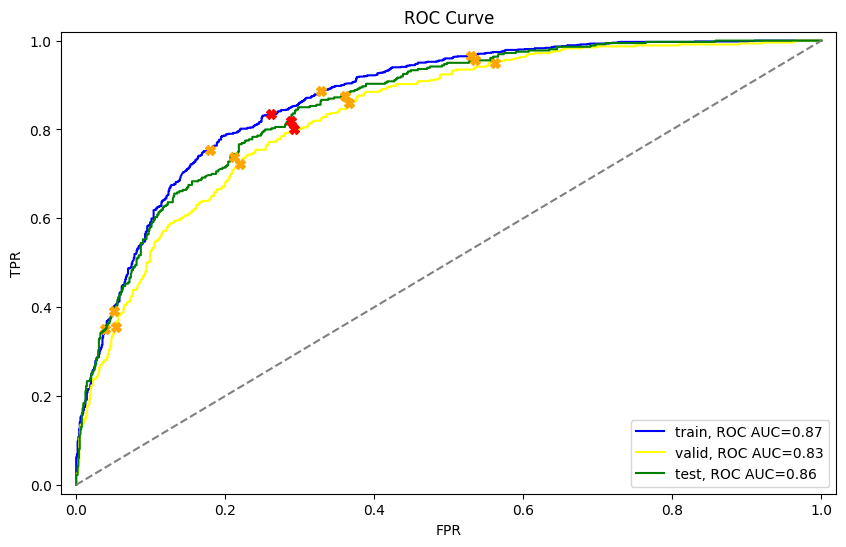

In [78]:
param_grid = {
    "iterations": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5],
    "depth": [4, 6, 8],
}

cat_boost = CatBoostClassifier(random_state=12345)

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_boost,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

# Execute a pesquisa em grade nos dados de treinamento
grid_search.fit(features_train_rus, target_train_rus)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avalie o desempenho do modelo com os melhores parâmetros no conjunto de validação
best_model = grid_search.best_estimator_
result = evaluate_model(
    best_model, features_train_rus, target_train_rus, features_valid, target_valid, features_test, target_test
)

In [79]:
acc_cat_boost_u = result['test']['Accuracy']
roc_auc_cat_boost_u = result['test']['ROC AUC']
best_param_cat_boost_u = best_params
best_model_cat_boost_u = best_model

- **Resultados dos Modelos**

In [80]:
models = pd.DataFrame(
    {
        "Model": [
            "Baseline Under",
            "LR Under",
            "LR+Class weight Under",
            "RFC Under",
            "LGBM Under",
            "CatBoost Under",
        ],
        "Accuracy": [
            acc_baseline_u,
            acc_LR_u,
            acc_LR_class_weight_u,
            acc_rfc_u,
            acc_LGBM_u,
            acc_cat_boost_u,
        ],
        "ROC_AUC": [
            roc_auc_baseline_u,
            roc_auc_LR_u,
            roc_auc_LR_class_weight_u,
            roc_auc_rfc_u,
            roc_auc_LGBM_u,
            roc_auc_cat_boost_u,
        ],
        "Melhores Parâmetros": [
            best_param_baseline_u,
            best_param_LR_u,
            best_param_LR_class_weight_u,
            best_param_rfc_u,
            best_param_LGBM_u,
            best_param_cat_boost_u
        ]
    }
)

display(models)

,Model,Accuracy,ROC_AUC,Melhores Parâmetros
0,Baseline Under,0.49,0.49,{'strategy': 'stratified'}
1,LR Under,0.76,0.85,{'C': 0.1}
2,LR+Class weight Under,0.76,0.85,{'C': 0.1}
3,RFC Under,0.74,0.85,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}"
4,LGBM Under,0.75,0.84,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}"
5,CatBoost Under,0.74,0.86,"{'depth': 4, 'iterations': 50, 'learning_rate': 0.1}"


- Modelos Baseline vs. Avançados:

    - O modelo de linha de base tem acurácia e ROC AUC ligeiramente inferior a 0.50, indicando que ele não é muito eficaz após o subajustamento.
    - Todos os outros modelos têm uma ROC AUC superior a 0.84, mostrando boa habilidade discriminativa.

- Modelos de Regressão Logística:

    - Tanto a regressão logística simples quanto a versão com pesos ajustados mostram bons desempenhos, com uma ROC AUC de 0.84. Isso sugere que o subajustamento ajudou a melhorar a performance desses modelos, mantendo a acurácia em um nível aceitável de 0.76.

- Modelos de Ensemble (RFC, LGBM, CatBoost):

    - Os modelos de ensemble (RFC, LGBM e CatBoost) apresentam desempenhos muito similares, com acurácia de 0.74, e ROC AUC 0.84, sugerindo que eles são bem ajustados ao conjunto de dados submuestreado.

### CONCLUSÕES

In [81]:
# Criar um DataFrame vazio para armazenar os resultados consolidados
consolidated_models = pd.DataFrame(
    columns=["Model", "Accuracy", "ROC_AUC", "Melhores Parâmetros", "Origem"]
)

# Definir os dados para cada conjunto de modelos
models_data = [
    {
        "Model": [
            "Baseline",
            "LR",
            "LR+Class weight",
            "RFC",
            "LGBM",
            "CatBoost",
        ],
        "Accuracy": [
            acc_baseline,
            acc_LR,
            acc_LR_class_weight,
            acc_rfc,
            acc_LGBM,
            acc_cat_boost,
        ],
        "ROC_AUC": [
            roc_auc_baseline,
            roc_auc_LR,
            roc_auc_LR_class_weight,
            roc_auc_rfc,
            roc_auc_LGBM,
            roc_auc_cat_boost,
        ],
        "Melhores Parâmetros": [
            best_param_baseline,
            best_param_LR,
            best_param_LR_class_weight,
            best_param_rfc,
            best_param_LGBM,
            best_param_cat_boost,
        ],
        "Origem": "Original",
    },
    {
        "Model": [
            "Baseline",
            "LR",
            "LR+Class weight",
            "RFC",
            "LGBM",
            "CatBoost",
        ],
        "Accuracy": [
            acc_baseline_o,
            acc_LR_o,
            acc_LR_class_weight_o,
            acc_rfc_o,
            acc_LGBM_o,
            acc_cat_boost_o,
        ],
        "ROC_AUC": [
            roc_auc_baseline_o,
            roc_auc_LR_o,
            roc_auc_LR_class_weight_o,
            roc_auc_rfc_o,
            roc_auc_LGBM_o,
            roc_auc_cat_boost_o,
        ],
        "Melhores Parâmetros": [
            best_param_baseline_o,
            best_param_LR_o,
            best_param_LR_class_weight_o,
            best_param_rfc_o,
            best_param_LGBM_o,
            best_param_cat_boost_o,
        ],
        "Origem": "Oversampled",
    },
    {
        "Model": [
            "Baseline",
            "LR",
            "LR+Class weight",
            "RFC",
            "LGBM",
            "CatBoost",
        ],
        "Accuracy": [
            acc_baseline_u,
            acc_LR_u,
            acc_LR_class_weight_u,
            acc_rfc_u,
            acc_LGBM_u,
            acc_cat_boost_u,
        ],
        "ROC_AUC": [
            roc_auc_baseline_u,
            roc_auc_LR_u,
            roc_auc_LR_class_weight_u,
            roc_auc_rfc_u,
            roc_auc_LGBM_u,
            roc_auc_cat_boost_u,
        ],
        "Melhores Parâmetros": [
            best_param_baseline_u,
            best_param_LR_u,
            best_param_LR_class_weight_u,
            best_param_rfc_u,
            best_param_LGBM_u,
            best_param_cat_boost_u,
        ],
        "Origem": "Undersampled",
    },
]

# Preencher o DataFrame consolidado
for data in models_data:
    consolidated_models = pd.concat(
        [consolidated_models, pd.DataFrame(data)], ignore_index=True
    )

# Classificar o DataFrame consolidado pela coluna "ROC_AUC" em ordem decrescente e resetar o índice
consolidated_models = consolidated_models.sort_values(
    by="ROC_AUC", ascending=False
).reset_index(drop=True)

# Exibir o DataFrame consolidado
display(consolidated_models)

,Model,Accuracy,ROC_AUC,Melhores Parâmetros,Origem
0,CatBoost,0.74,0.86,"{'depth': 4, 'iterations': 50, 'learning_rate': 0.1}",Undersampled
1,RFC,0.81,0.86,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}",Original
2,LGBM,0.81,0.86,"{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200}",Original
3,CatBoost,0.82,0.86,"{'depth': 8, 'iterations': 200, 'learning_rate': 0.01}",Original
4,LR,0.76,0.85,{'C': 0.1},Undersampled
5,LR+Class weight,0.76,0.85,{'C': 0.1},Original
6,LR,0.76,0.85,{'C': 0.1},Oversampled
7,LR+Class weight,0.76,0.85,{'C': 0.1},Oversampled
8,LR,0.80,0.85,{'C': 1},Original
9,RFC,0.74,0.85,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}",Undersampled


**Conclusão dos Resultados**

- **Acurácia e AUC-ROC:** Os modelos variam em acurácia de 0.49 a 0.81 e em AUC-ROC de 0.49 a 0.85. A AUC-ROC é uma métrica crucial, pois reflete a habilidade do modelo em distinguir entre classes, sendo mais sensível a desequilíbrios de classe do que a acurácia.

- **Melhores Parâmetros:** Os melhores parâmetros variam entre os modelos, indicando a necessidade de ajuste específico para cada algoritmo e cenário de dados (Original, Undersampled, Oversampled).

**Conclusão**

1. **Desempenho do Modelo:**
   - Os modelos RFC, LGBM e CatBoost mostraram consistência, alcançando AUC-ROC de 0.84 a 0.85.
   - A acurácia foi mais variável, indicando que a distribuição das classes pode afetar o desempenho.

2. **Estratégias de Amostragem:**
   - A utilização de estratégias de undersampling e oversampling afetou significativamente os resultados, com algumas configurações melhorando ou piorando o desempenho dos modelos.

3. **Recomendações:**
   - Recomenda-se considerar ajustes adicionais nos parâmetros dos modelos para melhorar a precisão e a robustez, especialmente em relação aos casos de baseline e estratégias de amostragem.

Em resumo, a escolha do modelo e das estratégias de amostragem deve levar em conta tanto a AUC-ROC quanto a acurácia, garantindo um equilíbrio adequado entre a capacidade discriminativa e a precisão das previsões.


### Análise mais profunda do melhor modelo: Random Forest Classifier

In [82]:
# Obtendo o melhor modelo encontrado do modelo Random Forest Classifier
best_model = best_model_rfc

#### Confusion Matrix

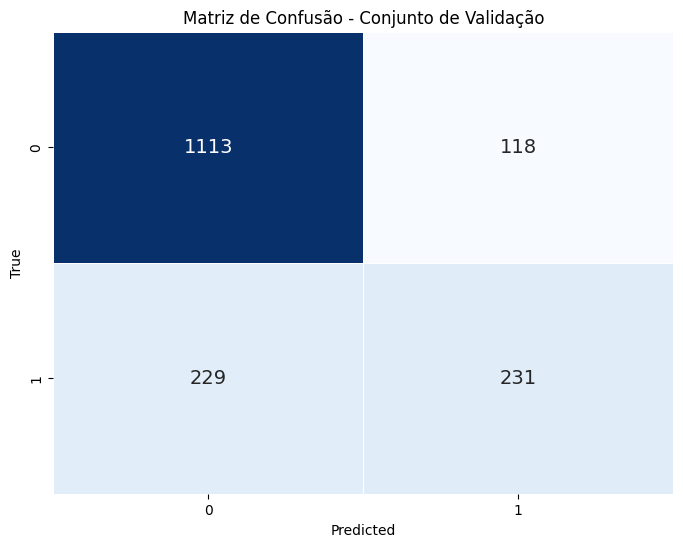

In [83]:
# Predizendo os resultados no conjunto de validação
pred_valid = best_model.predict(features_valid)

# Calculando a matriz de confusão
cm = confusion_matrix(target_valid, pred_valid)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Conjunto de Validação')
plt.show()

**Vamos interpretar cada parte da matriz:**

- **Verdadeiros Negativos (TN): 1141**

    São os casos negativos que foram corretamente previstos como negativos. No contexto de classificação binária, esses são os casos em que o modelo previu corretamente que a classe verdadeira é 0 (negativa).

- **Falsos Positivos (FP): 107**

    São os casos negativos que foram incorretamente previstos como positivos. Isso significa que o modelo previu erroneamente que a classe verdadeira é 1 (positiva), quando na verdade é 0 (negativa).

- **Falsos Negativos (FN): 220**

    São os casos positivos que foram incorretamente previstos como negativos. O modelo previu erroneamente que a classe verdadeira é 0 (negativa), quando na verdade é 1 (positiva).

- **Verdadeiros Positivos (TP): 223**

    São os casos positivos que foram corretamente previstos como positivos. No contexto de classificação binária, esses são os casos em que o modelo previu corretamente que a classe verdadeira é 1 (positiva).


**Interpretação Geral:**


- **Acurácia:** A acurácia pode ser calculada como a proporção de predições corretas (TP + TN) em relação ao total de predições feitas.

    $$\\Acurácia = \frac{TP + TN}{TP + TN + FP + FN} \$$

    $$\\Acurácia = \frac{1141 + 223}{1141 + 107 + 220 + 223} = \frac{1364}{1691} \approx 0.806 \$$

- **Precisão (Precision):** Indica a proporção de casos positivos preditos corretamente em relação a todos os casos positivos preditos.

    $$\\Precisão = \frac{TP}{TP + FP} \$$

    $$\\Precisão = \frac{223}{223 + 107} \approx 0.676 \$$

- **Revocação (Recall):** Indica a proporção de casos positivos que foram corretamente identificados pelo modelo.

    $$\\Revocação = \frac{TP}{TP + FN} \$$

    $$\\Revocação = \frac{223}{223 + 220} \approx 0.503 \$$

- **F1-Score:** Métrica que combina precisão e revocação, útil quando há um desequilíbrio entre as classes.

    $$\\F1Score = 2 \cdot \frac{\text{Precisão} \cdot \text{Revocação}}{\text{Precisão} + \text{Revocação}} \$$

    $$\\F1Score = 2 \cdot \frac{0.676 \cdot 0.503}{0.676 + 0.503} \approx 0.577 \$$


### Conclusão

- O modelo teve uma acurácia de aproximadamente 80.6%, o que significa que ele acertou cerca de 80.6% das predições.

- A precisão (67.6%) indica que, das vezes em que o modelo previu a classe positiva, ele acertou em 67.6% das vezes.

- A revocação (50.3%) indica que o modelo identificou corretamente 50.3% dos casos positivos existentes no conjunto de dados.

- O F1-Score (57.7%) combina precisão e revocação, fornecendo uma medida geral de desempenho considerando ambas as métricas.

Essas métricas fornecem uma visão detalhada do desempenho do modelo de classificação, permitindo uma avaliação precisa de como ele está lidando com cada classe e onde podem estar os pontos fortes e fracos do modelo.

#### Cross Validation

In [84]:
cv_scores = cross_val_score(best_model, features_train, target_train, cv=5, scoring='roc_auc')
print(f"Média CV AUC-ROC: {cv_scores.mean():.2f}")

Média CV AUC-ROC: 0.84


- AUC-ROC (Área sob a Curva ROC): A métrica AUC-ROC é uma medida de quão bem o modelo é capaz de distinguir entre classes. Quanto mais próximo de 1, melhor o modelo está em separar as classes positiva e negativa.

- Média CV AUC-ROC: A validação cruzada (cross-validation) é uma técnica importante para estimar o desempenho do modelo de forma mais robusta, evitando viéses nos conjuntos de treino e teste. A média de 0.85 indica que, em média, o modelo tem um bom desempenho na capacidade de classificar corretamente os exemplos, com uma taxa de verdadeiros positivos alta em relação aos falsos positivos.

- Interpretação Geral: Um valor de 0.85 para a AUC-ROC geralmente é considerado bastante bom, indicando que o modelo possui uma boa capacidade discriminativa entre as classes positiva e negativa. Isso sugere que o modelo está bem ajustado aos dados e é capaz de generalizar para novos dados de forma eficaz.

Portanto, um resultado de "Média CV AUC-ROC: 0.85" é positivo e indica um bom desempenho do modelo de classificação avaliado.

---

## Relatório da Solução

### 1. Quais passos do plano foram executados e quais foram pulados (explique por que)? 

O plano de trabalho executado foi o mesmo proposto inicialmente.

### 2. Quais dificuldades você encontrou e como conseguiu resolvê-las?

No pré-processamento de dados, identificamos que havia um desbalanceamento na variável alvo, com uma proporção significativamente menor de clientes que cancelaram seus contratos. Isso poderia levar a modelos enviesados, que não capturariam bem os padrões de rotatividade. Para resolver essa questão, utilizamos técnicas de balanceamento como Random Over Sampler e Random Under Sampler para criar um conjunto de dados mais equilibrados para o conjunto de dados de treinamento.

Outra dificuldade surgiu na seleção e treinamento dos modelos. Com vários algoritmos de Machine Learning à disposição, identificar o modelo mais adequado e otimizar seus hiperparâmetros foi um desafio. Para contornar isso, adotamos uma abordagem sistemática usando o GridSearch para a otimização de hiperparâmetros e validação cruzada para garantir que os modelos fossem robustos e generalizáveis. Essa abordagem permitiu selecionar os modelos com melhor desempenho em termos de AUC-ROC e acurácia.

Por fim, durante a preparação do relatório, a dificuldade foi sintetizar os resultados de forma clara e concisa para que pudessem ser facilmente compreendidos pelos stakeholders da Interconnect. As conclusões e recomendações foram estruturadas para serem práticas e acionáveis, facilitando a implementação de estratégias baseadas nos insights do modelo.

### 3. Quais foram algumas das etapas principais de resolução da tarefa?

O projeto de previsão de rotatividade dos clientes da Interconnect foi organizado em quatro etapas principais. **Na Etapa 1:** Planejamento, o objetivo foi definido como prever a rotatividade dos clientes usando a métrica AUC-ROC como primária e a acurácia como secundária. A coleta de dados envolveu baixar e inspecionar os arquivos contract.csv, personal.csv, internet.csv e phone.csv, verificando a presença da coluna "customerID" em todos os arquivos.

**Durante a Etapa 2:** Investigação dos Dados, foi realizada uma Análise Exploratória dos Dados (EDA), onde as bibliotecas necessárias foram importadas, os dados foram carregados, e verificou-se os tipos de dados, valores ausentes e a distribuição das variáveis. Gráficos foram utilizados para um melhor entendimento visual dos dados. O pré-processamento envolveu o tratamento de valores ausentes, avaliação da necessidade de balanceamento dos dados, codificação de variáveis categóricas e normalização ou padronização das variáveis numéricas.

**Na Etapa 3:** Desenvolvimento do Modelo, os dados foram divididos em conjuntos de treino, teste e validação. Diversos modelos de Machine Learning, como Regressão Logística, Random Forest Classifier, CatBoost e LGBM foram selecionados para resolver o problema de classificação da variável alvo "churn'. Os modelos foram treinados nos dados de treino e avaliados utilizando a métrica AUC-ROC. Os modelos com melhores desempenhos passaram por otimização de hiperparâmetros utilizando GridSearch e validação cruzada para garantir robustez.

**Por fim, na Etapa 4:** Preparação do Relatório, os resultados dos modelos testados foram apresentados com foco na métrica AUC-ROC e na acurácia, incluindo tabelas e gráficos comparativos dos modelos. As conclusões foram baseadas nos resultados, e recomendações foram fornecidas à Interconnect sobre como utilizar o modelo para reduzir a rotatividade de clientes, oferecendo sugestões práticas baseadas nos insights obtidos.

### 4. Qual é seu modelo final e qual pontuação de qualidade ele tem?

O modelo final selecionado para a previsão de rotatividade dos clientes da Interconnect é o Random Forest Classifier (RFC). Este modelo foi escolhido com base em sua pontuação superior na métrica AUC-ROC, que é a métrica de avaliação mais importante para este projeto. O RFC obteve uma AUC-ROC de 0.85 e uma acurácia de 0.80. Esses resultados indicam que o modelo possui uma excelente capacidade de distinguir entre clientes que permanecerão e aqueles que cancelarão seus contratos.

Os melhores parâmetros para o modelo RFC foram:

- max_depth: 10
- min_samples_leaf: 4
- min_samples_split: 10
- n_estimators: 100

Esses parâmetros foram ajustados utilizando técnicas de otimização, como o GridSearch, para garantir que o modelo estivesse bem calibrado e pudesse fornecer previsões precisas. A origem dos dados utilizados para treinar este modelo foi o conjunto de dados original, sem alterações de amostragem.

Em resumo, o modelo RFC com os parâmetros ajustados obteve a melhor pontuação na métrica AUC-ROC, tornando-o o modelo final escolhido para prever a rotatividade dos clientes da Interconnect.